In [1]:
!pip install tensorflow numpy opencv-python

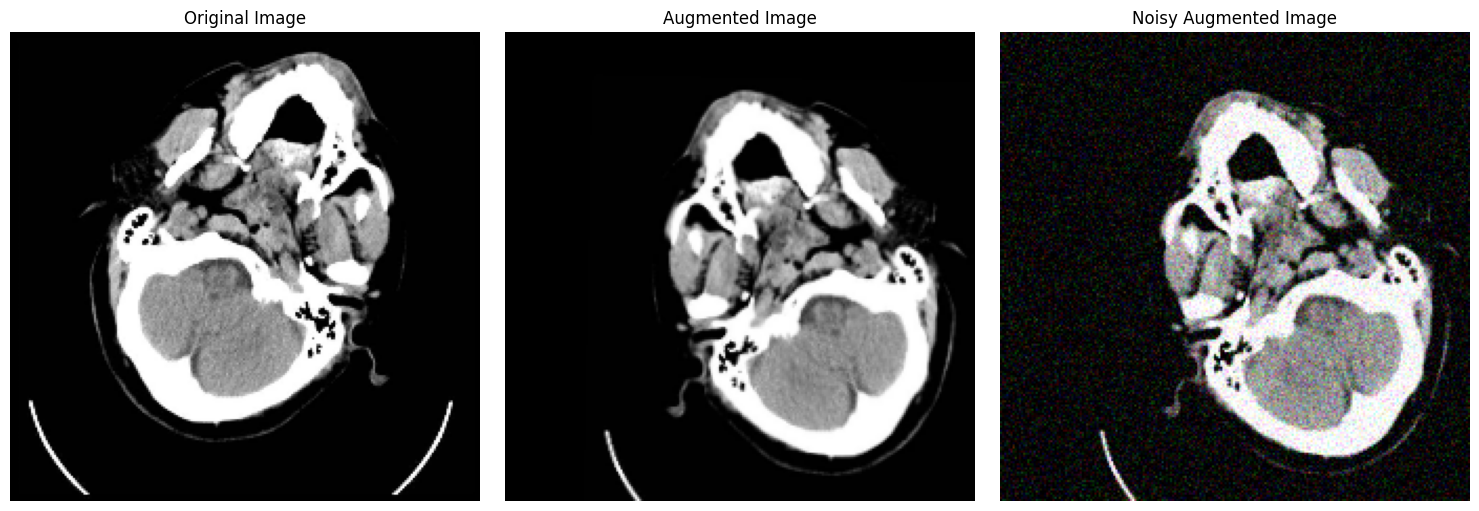

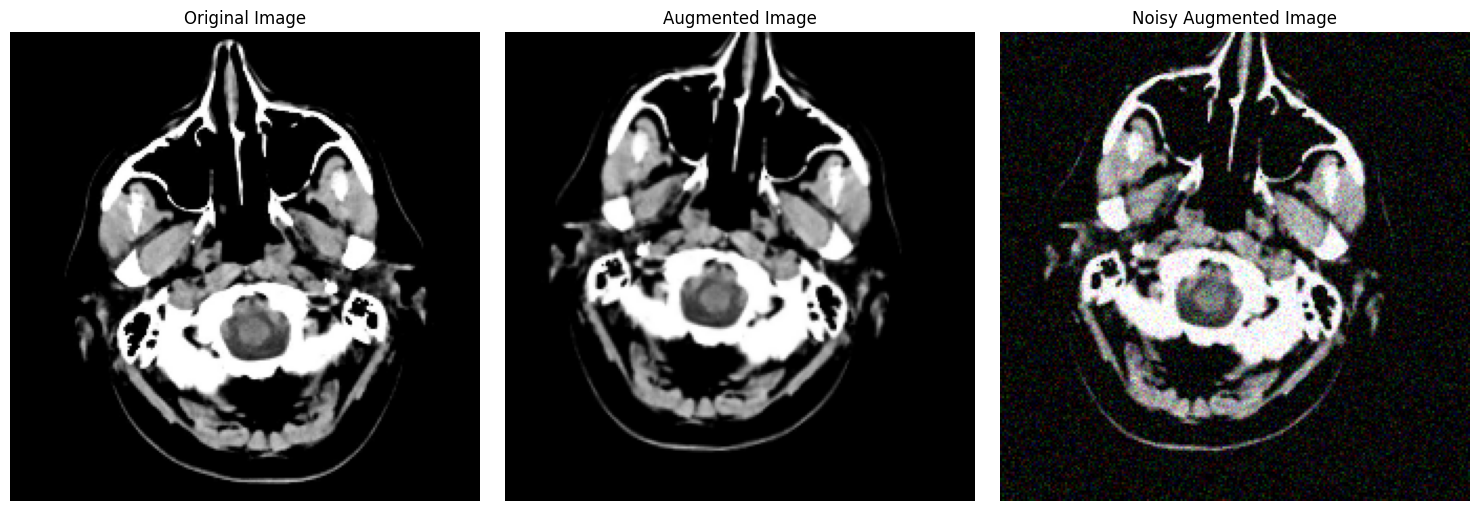

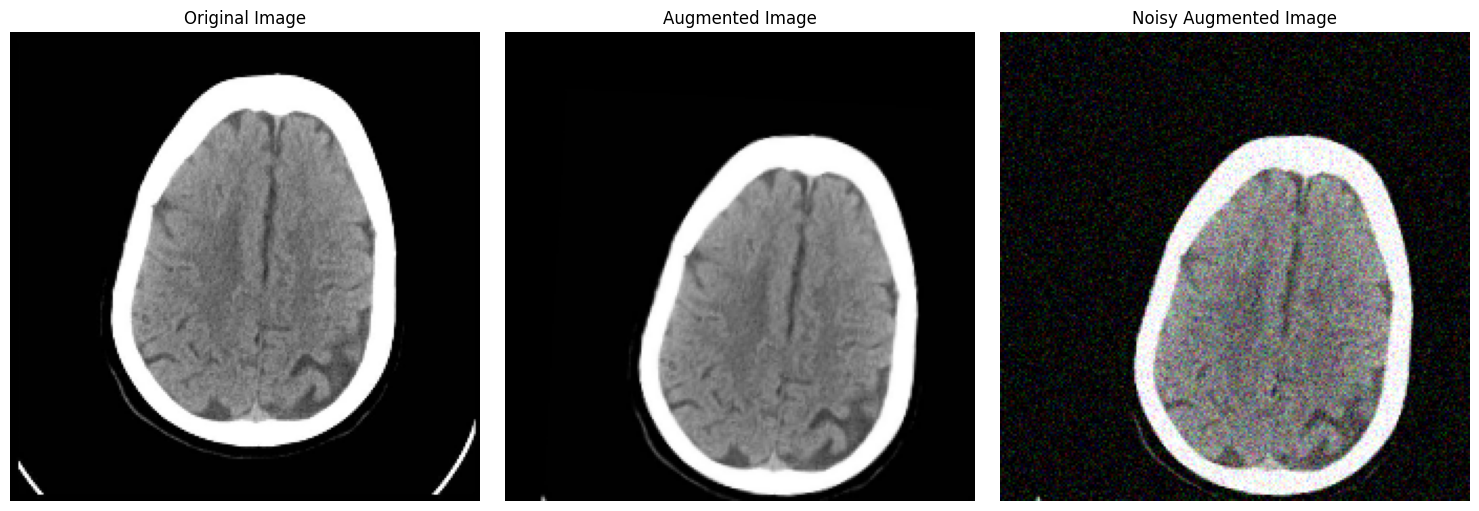

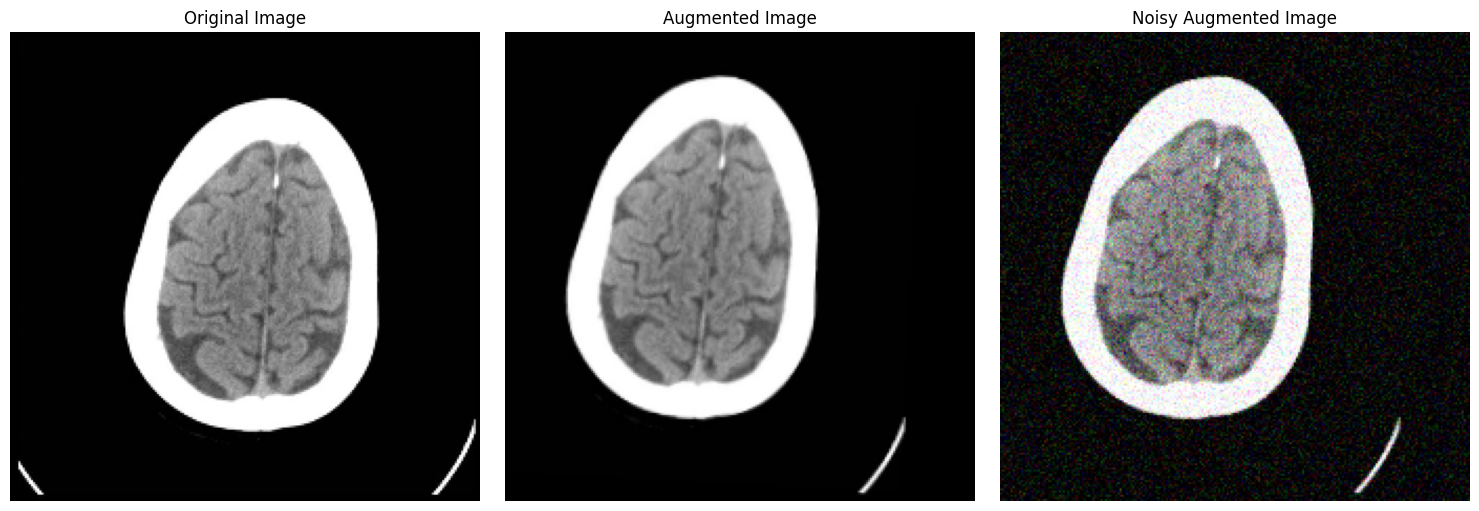

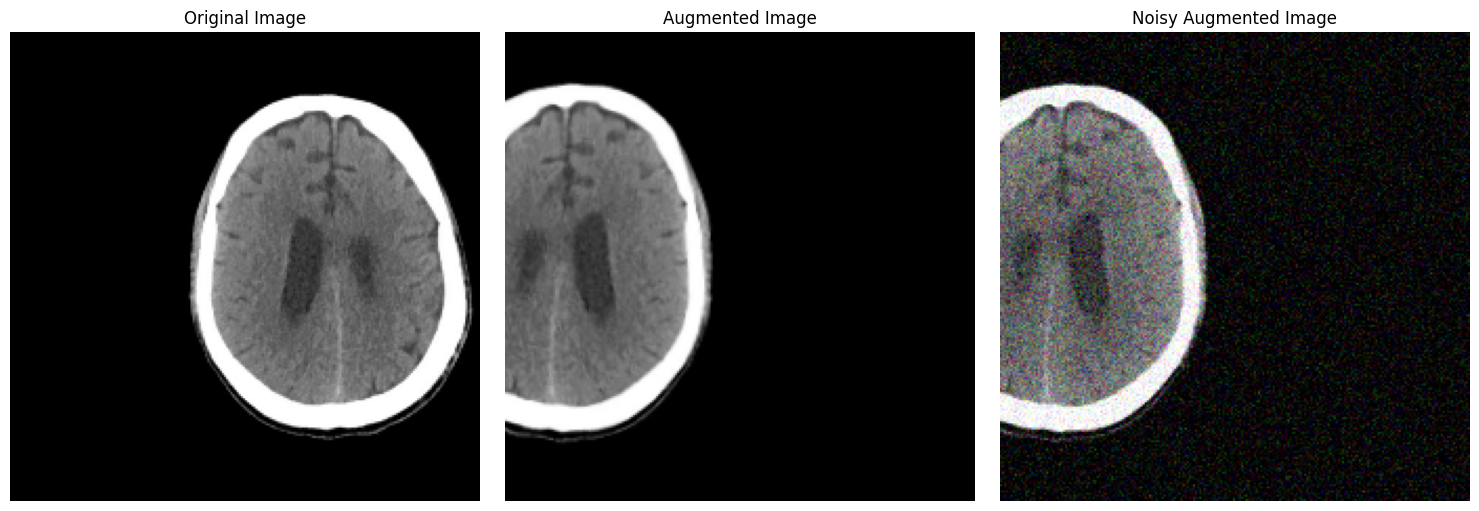

In [2]:
import os
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Function to add Gaussian noise
def add_gaussian_noise(image, mean=0, std=25):
    gaussian = np.random.normal(mean, std, image.shape).astype(np.float32)
    noisy_image = image.astype(np.float32) + gaussian
    noisy_image = np.clip(noisy_image, 0, 255).astype(np.uint8)
    return noisy_image

# Paths
dataset_dir = 'dataset'
classes = ['normal', 'stroke']
target_size = (224, 224)

# Image augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=5,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.05,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Number of samples to display
num_samples = 5

for sample_idx in range(num_samples):
    # Randomly select a class and an image
    selected_class = random.choice(classes)
    class_dir = os.path.join(dataset_dir, selected_class)
    image_name = random.choice(os.listdir(class_dir))
    image_path = os.path.join(class_dir, image_name)

    # Load and preprocess the image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Image at path {image_path} could not be loaded. Skipping.")
        continue
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, target_size)

    # Generate augmented image
    image_expanded = np.expand_dims(image, 0)
    aug_iter = datagen.flow(image_expanded, batch_size=1)
    aug_image = next(aug_iter)[0].astype(np.uint8)

    # Add Gaussian noise to the augmented image
    noisy_image = add_gaussian_noise(aug_image)

    # Display the images
    titles = ['Original Image', 'Augmented Image', 'Noisy Augmented Image']
    images = [image, aug_image, noisy_image]

    plt.figure(figsize=(15, 5))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.imshow(images[i])
        plt.title(titles[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()


# Data Preprocessing and CNN Model Training

Let's preprocess the dataset and build a CNN model for stroke detection:
1. Load and preprocess all images with noise augmentation
2. Split data into train/validation sets
3. Create and train CNN model using transfer learning with VGG16

In [3]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models
import numpy as np
import os

# Load and preprocess all images
X = []
y = []

for class_idx, class_name in enumerate(classes):
    class_dir = os.path.join(dataset_dir, class_name)
    for img_name in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_name)

        # Load and resize image
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, target_size)

        # Add noise
        img = add_gaussian_noise(img)

        # Normalize
        img = img.astype('float32') / 255.0

        X.append(img)
        y.append(class_idx)

X = np.array(X)
y = np.array(y)
y = to_categorical(y)

In [4]:
# Split data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Load VGG16 base model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

# Create model
model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(2, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [5]:
# Train model
history = model.fit(
    X_train,
    y_train,
    batch_size=16,
    epochs=15,
    validation_data=(X_val, y_val)
)

Epoch 1/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 201s 2s/step - accuracy: 0.5880 - loss: 2.9994 - val_accuracy: 0.7106 - val_loss: 0.5985
Epoch 2/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 187s 1s/step - accuracy: 0.7141 - loss: 0.5567 - val_accuracy: 0.7325 - val_loss: 0.5310
Epoch 3/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 197s 2s/step - accuracy: 0.7226 - loss: 0.5213 - val_accuracy: 0.8004 - val_loss: 0.4579
Epoch 4/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 177s 1s/step - accuracy: 0.7645 - loss: 0.4662 - val_accuracy: 0.8244 - val_loss: 0.4419
Epoch 5/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 164s 1s/step - accuracy: 0.7551 - loss: 0.4609 - val_accuracy: 0.7385 - val_loss: 0.4851
Epoch 6/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 100s 800ms/step - accuracy: 0.7601 - loss: 0.4868 - val_accuracy: 0.8683 - val_loss: 0.4300
Epoch 7/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 97s 774ms/step - accuracy: 0.7182 - loss: 0.4709 - val_accuracy: 0.7505 - val_loss: 0.4385
Epoch 8/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 104s 833ms/step - accuracy: 0.7247 - loss: 0.4740 - 

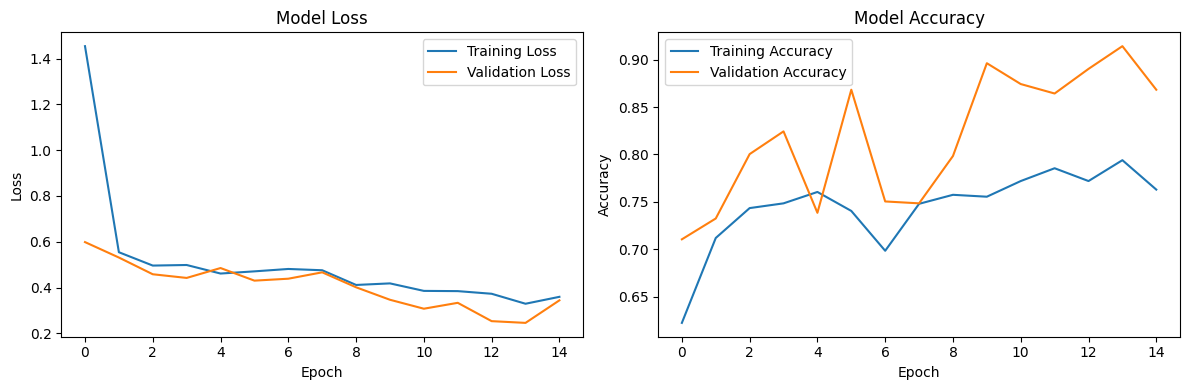

In [6]:
# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


# Save the trained model and evaluate it on the combined dataset:
1. Save the model
2. Load and preprocess images from combined_dataset
3. Make predictions and calculate accuracy

In [7]:
# Save the model
model.save('stroke_detection_model.h5')

In [8]:
# Load and preprocess images from combined_dataset
combined_X = []
combined_y = []

# Process images from combined_dataset directory
for class_name in classes:
    class_dir = os.path.join('combined_dataset', class_name)
    for img_name in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_name)

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, target_size)
        img = img.astype('float32') / 255.0

        combined_X.append(img)
        combined_y.append(1 if class_name == 'stroke' else 0)

combined_X = np.array(combined_X)
combined_y = np.array(combined_y)
combined_y = to_categorical(combined_y)

In [9]:
# Evaluate model on combined dataset
test_loss, test_accuracy = model.evaluate(combined_X, combined_y)
print(f'\nTest accuracy on combined dataset: {test_accuracy:.4f}')

# Make predictions
predictions = model.predict(combined_X)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(combined_y, axis=1)

from sklearn.metrics import classification_report

print('\nClassification Report:')
print(classification_report(true_classes, predicted_classes, target_names=classes))


391/391 ━━━━━━━━━━━━━━━━━━━━ 484s 1s/step - accuracy: 0.7742 - loss: 0.6746

Test accuracy on combined dataset: 0.6737
391/391 ━━━━━━━━━━━━━━━━━━━━ 487s 1s/step

Classification Report:
              precision    recall  f1-score   support

      normal       0.70      0.83      0.76      7755
      stroke       0.60      0.41      0.49      4750

    accuracy                           0.67     12505
   macro avg       0.65      0.62      0.63     12505
weighted avg       0.66      0.67      0.66     12505

